In [3]:
#import fitz
import os
import re
import requests

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

from chromadb.api.types import EmbeddingFunction
from dotenv import load_dotenv

from ibm_watson_machine_learning.foundation_models import Model
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams

from langchain.document_loaders import PyPDFLoader
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from typing import Literal, Optional, Any

In [4]:
def pdf_to_text(path: str, 
                start_page: int = 1, 
                end_page: Optional[int | None] = None) -> list[str]:
    """
    Converts PDF to plain text.

    Params:
        path (str): Path to the PDF file.
        start_page (int): Page to start getting text from.
        end_page (int): Last page to get text from.
    """
    loader = PyPDFLoader("PDF/COI...pdf")
    pages = loader.load()
    total_pages = len(pages)

    if end_page is None:
        end_page = len(pages)

    text_list = []
    for i in range(start_page-1, end_page):
        text = pages[i].page_content
        text = text.replace('\n', ' ')
        text = re.sub(r'\s+', ' ', text)
        text_list.append(text)

    return text_list

In [5]:
# PDF files available:
#    "pdfs/pie_recipe.pdf"
#    "pdfs/paper_flowers.pdf"
text_list = pdf_to_text("PDF/COI...pdf")
print(text_list)

[' THE CONSTITUTION OF INDIA [As on 26th November , 2021 ] ', '2 PREFACE This is the fifth pocket size edition of the Constitution of India in the diglot form. In this edition, the text of the Constitution of India has been brought up -to-date by incorporating therein all the amendments up to the Constitution (One Hundred and Fifth Amendment) A ct, 2021. The foot notes below the text indicate the Constitution Amendment Acts by which such amendments have been made. The Constitution (One Hundredth Amendments ) Act, 2015 containing details of acquired and transferred territories between the Governme nts of India and Bangladesh has been provided in APPENDIX I. The Constitution (Application to Jammu and Kashmir) Order, 2019 and the declaration under article 370(3) of the Constitution have been provided respectively in Appendix II and Appendix III for reference. New Delhi; Dr. Reeta Vasishta, Secretary to the Government of India. ', '3 THE CONSTITUTION OF INDIA ____________ CONTENTS ________

In [6]:
def text_to_chunks(texts: list[str], 
                   word_length: int = 150, 
                   start_page: int = 1) -> list[list[str]]:
    """
    Splits the text into equally distributed chunks.

    Args:
        texts (str): List of texts to be converted into chunks.
        word_length (int): Maximum number of words in each chunk.
        start_page (int): Starting page number for the chunks.
    """
    text_toks = [t.split(' ') for t in texts]
    chunks = []

    for idx, words in enumerate(text_toks):
        for i in range(0, len(words), word_length):
            chunk = words[i:i+word_length]
            if (i+word_length) > len(words) and (len(chunk) < word_length) and (
                len(text_toks) != (idx+1)):
                text_toks[idx+1] = chunk + text_toks[idx+1]
                continue
            chunk = ' '.join(chunk).strip() 
            chunk = f'[Page no. {idx+start_page}]' + ' ' + '"' + chunk + '"'
            chunks.append(chunk)
            
    return chunks

In [7]:
chunks = text_to_chunks(text_list)

for chunk in chunks:
    print(chunk + '\n')

[Page no. 2] "THE CONSTITUTION OF INDIA [As on 26th November , 2021 ]  2 PREFACE This is the fifth pocket size edition of the Constitution of India in the diglot form. In this edition, the text of the Constitution of India has been brought up -to-date by incorporating therein all the amendments up to the Constitution (One Hundred and Fifth Amendment) A ct, 2021. The foot notes below the text indicate the Constitution Amendment Acts by which such amendments have been made. The Constitution (One Hundredth Amendments ) Act, 2015 containing details of acquired and transferred territories between the Governme nts of India and Bangladesh has been provided in APPENDIX I. The Constitution (Application to Jammu and Kashmir) Order, 2019 and the declaration under article 370(3) of the Constitution have been provided respectively in Appendix II and Appendix III for reference. New Delhi; Dr. Reeta Vasishta, Secretary to the Government"

[Page no. 4] "of India.  3 THE CONSTITUTION OF INDIA _________

In [8]:
%%time
# Load the model from TF Hub
class MiniLML6V2EmbeddingFunction(EmbeddingFunction):
    MODEL = SentenceTransformer('all-MiniLM-L6-v2')
    def __call__(self, texts):
        return MiniLML6V2EmbeddingFunction.MODEL.encode(texts).tolist()
emb_function = MiniLML6V2EmbeddingFunction()

CPU times: user 1.08 s, sys: 1.02 s, total: 2.1 s
Wall time: 4.06 s


In [9]:
def get_text_embedding(texts: list[list[str]], 
                       batch: int = 1000) -> list[Any]:
        """
        Get the embeddings from the text.

        Args:
            texts (list(str)): List of chucks of text.
            batch (int): Batch size.
        """
        embeddings = []
        for i in range(0, len(texts), batch):
            text_batch = texts[i:(i+batch)]
            # Embeddings model
            emb_batch = emb_function(text_batch)
            embeddings.append(emb_batch)
        embeddings = np.vstack(embeddings)
        return embeddings

In [10]:
embeddings = get_text_embedding(chunks)

print(embeddings.shape)
print(f"Our text was embedded into {embeddings.shape[1]} dimensions")

(940, 384)
Our text was embedded into 384 dimensions


In [11]:
print(embeddings[0])

[-5.19218342e-03  5.67179099e-02  4.72034328e-02 -7.60363638e-02
 -4.27707396e-02  4.48041558e-02 -4.10233475e-02  6.34250715e-02
 -5.54050021e-02  4.58392082e-03 -2.03526299e-02  4.62044775e-02
  5.84051087e-02 -2.36612130e-02  7.50224143e-02  1.72871724e-02
 -2.83012968e-02 -2.85542998e-02 -2.34856568e-02 -3.35470214e-02
  9.19130594e-02  9.65064913e-02 -5.16581535e-02 -5.40966280e-02
 -1.55354291e-02 -1.89405754e-02 -9.82962828e-03 -1.06752284e-01
  4.22351621e-03 -1.78286452e-02 -2.89270598e-02  4.48786914e-02
 -9.05796736e-02  4.41666227e-03  1.21148797e-02 -5.91276139e-02
 -2.07311325e-02  2.90236231e-02  7.85081387e-02 -6.43818527e-02
  5.14546111e-02 -6.21929243e-02  1.60453934e-02  4.66971323e-02
  4.37021814e-02  1.78476293e-02 -3.18070315e-02  3.63066494e-02
 -6.68592453e-02  2.58295611e-02 -4.86999229e-02  5.53872529e-03
 -4.17633075e-03  6.65839314e-02  1.66865736e-02 -1.00026913e-01
 -1.22487927e-02 -2.13211142e-02 -1.14376219e-02 -9.11085881e-05
  3.71999033e-02  8.49309

In [12]:
# question = 'How many people does this pie serve?'
question = 'Which article states the benefits of employees?'
emb_question = emb_function([question])

In [13]:

# Create a t-SNE model
tsne = TSNE(n_components=2, random_state=42)
embeddings_with_question = np.vstack([embeddings, emb_question])
embeddings_2d = tsne.fit_transform(embeddings_with_question)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
embeddings_2d.shape

(941, 2)

In [15]:
def visualize_embeddings(embeddings_2d: np.ndarray, 
                         question: Optional[bool] = False, 
                         neighbors: Optional[np.ndarray] = None) -> None:
    """
    Visualize 384-dimensional embeddings in 2D using t-SNE, label each data point with its index,
    and optionally plot a question data point as a red dot with the label 'q'.

    Args:
        embeddings (numpy.array): An array of shape (num_samples, 384) containing the embeddings.
        question (numpy.array, optional): An additional 384-dimensional embedding for the question.
                                          Default is None.
    """

    # Scatter plot the 2D embeddings and label each data point with its index
    plt.figure(figsize=(10, 8))
    num_samples = embeddings.shape[0]
    if neighbors is not None:
        for i, (x, y) in enumerate(embeddings_2d[:num_samples]):
            if i in neighbors:
                plt.scatter(x, y, color='purple', alpha=0.7)
                plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
            else:
                plt.scatter(x, y, color='blue', alpha=0.7)
                plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
    else:
        for i, (x, y) in enumerate(embeddings_2d[:num_samples]):
            plt.scatter(x, y, color='blue', alpha=0.7)
            plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
        
    # Plot the question data point if provided
    if question:
        x, y = embeddings_2d[-1]  # Last point corresponds to the question
        plt.scatter(x, y, color='red', label='q')
        plt.annotate('q', xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')

    plt.title('t-SNE Visualization of 384-dimensional Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

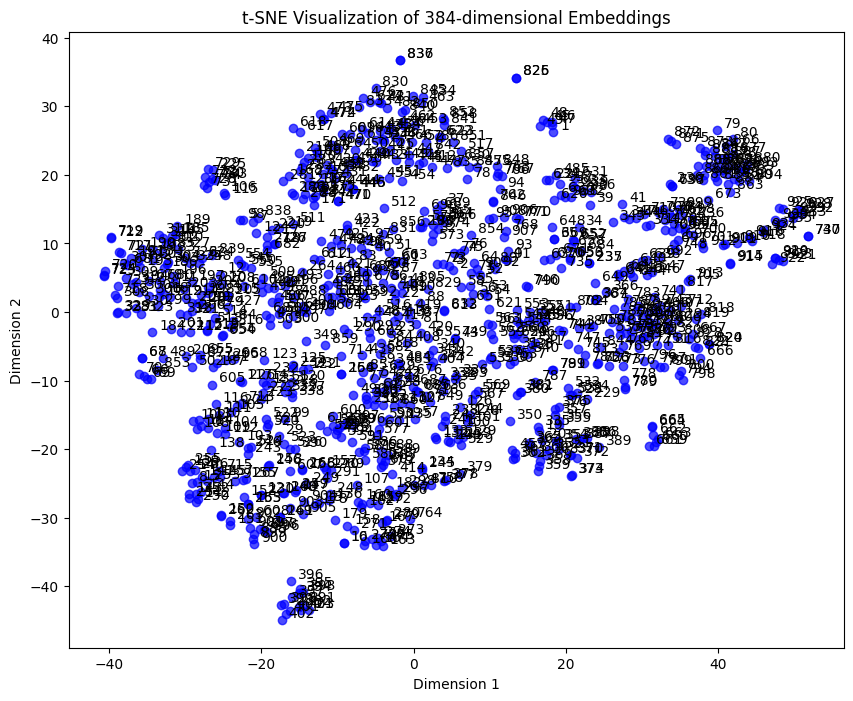

In [16]:
visualize_embeddings(embeddings_2d[:-1])

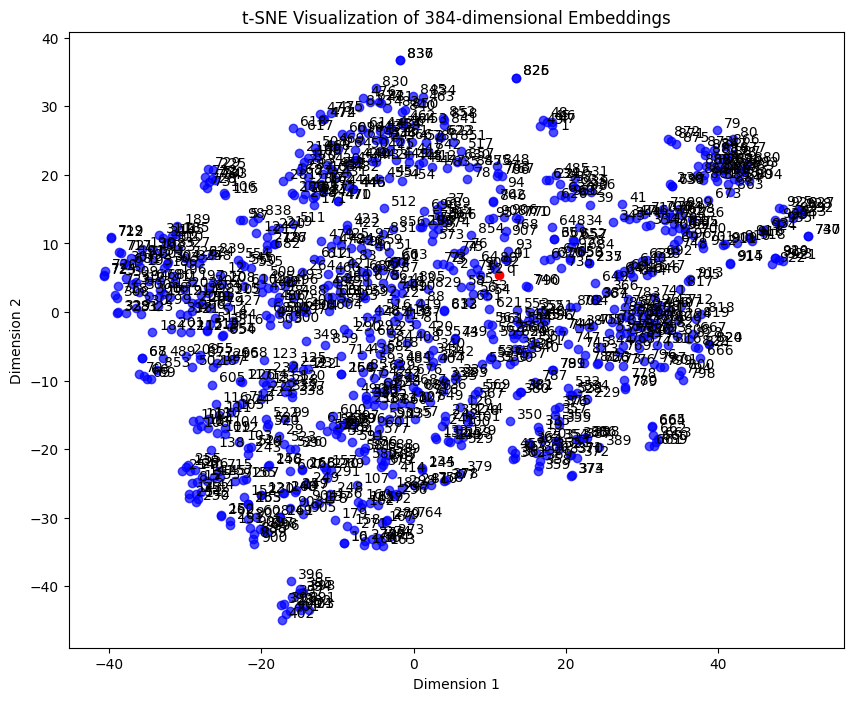

In [17]:
visualize_embeddings(embeddings_2d, True)

In [18]:
nn_2d = NearestNeighbors(n_neighbors=5)
nn_2d.fit(embeddings_2d[:-1])

NearestNeighbors()

In [19]:
neighbors = nn_2d.kneighbors(embeddings_2d[-1].reshape(1, -1), return_distance=False)
neighbors

array([[92, 89, 91, 52,  4]])

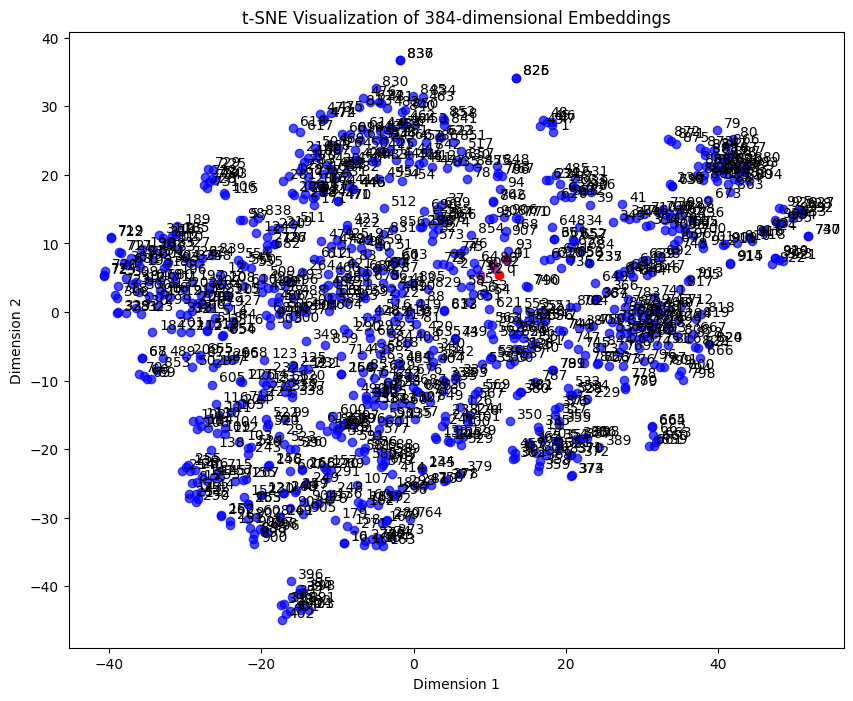

In [20]:
visualize_embeddings(embeddings_2d, True, neighbors)

In [21]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(embeddings)

NearestNeighbors()

In [30]:
# question = 'How many people does this pie serve?'
question = 'What is the Eligibility for re-election?'
emb_question = emb_function([question])

In [31]:
neighbors = nn.kneighbors(emb_question, return_distance=False)
neighbors

array([[103, 897, 523, 246, 898]])

In [32]:
topn_chunks = [chunks[i] for i in neighbors.tolist()[0]]

In [38]:
def build_prompt(question):
    prompt = ""
    prompt += 'Search results:\n'
    
    for c in topn_chunks:
        prompt += c + '\n\n'
    
    prompt += "Instructions: You are a conversational AI assistant that is provided a list of documents and a user query to answer based on information from the documents. The user also provides an answer mode which can be 'Grounded' or 'Mixed'. For answer mode Grounded only respond with exact facts from documents, for answer mode Mixed answer using facts from documents and your own knowledge. Cite all facts from the documents using <co: doc_id></co> tags."\
            "Compose a comprehensive reply to the query using the search results given. "\
            "Cite each reference using [Page Number] notation (every result has this number at the beginning). "\
            "Citation should be done at the end of each sentence. If the search results mention multiple subjects "\
            "with the same name, create separate answers for each. Only include information found in the results and "\
            "don't add any additional information. Make sure the answer is correct and don't output false content. "\
            "If the text does not relate to the query, simply state 'Found Nothing'. Ignore outlier "\
            "search results which has nothing to do with the question. Only answer what is asked. The "\
            "answer should be short and concise." 
    
    prompt += f"\n\n\nQuery: {question}\n\nAnswer: "
    
    return prompt

In [39]:
prompt = build_prompt(question)
print(prompt)

Search results:
[Page no. 59] "(1) shall forthwith be communicated by him to the Speaker of the House of the People. 1. Subs. by the Constitution (Forty -second Amendment) Act, 1976, s. 12, for the Explanation (w.e.f. 3 -1-1977). 2. Subs. by the Constitution (Eighty -fourth Amendment) Act, 2001, s. 2, for "2000" (w.e.f. 21 - 2-2002).  59 57. Eligibility for re -election. —A person who holds, or who has held, office as President shall, subject to the other provisions of this Const itution, be eligible for re -election to that office. 58. Qualifications for election as President .—(1) No person shall be eligible for election as President unless he — (a) is a citizen of India, (b) has completed the age of thirty -five years, and (c) is qu alified for election as a member of the House of the People. (2) A person shall not be eligible for election as President if"

[Page no. 377] "5 (w.e.f. 1 -1-2004). 3. Subs. by s. 5, ibid., for "paragraphs 3, 4 and 5". (w.e.f. 1 -1-2004).  377 (i) where 

In [40]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from ctransformers import AutoModelForCausalLM,AutoConfig


In [41]:
def send_to_llm(input):
# Set gpu_layers to the number of layers to offload to GPU. Set to 0 if no GPU acceleration is available on your system.
    config = AutoConfig.from_pretrained("TheBloke/SciPhi-Self-RAG-Mistral-7B-32k-GGUF")
    config.config.max_new_tokens = 2048
    config.config.context_length = 4096
    llm = AutoModelForCausalLM.from_pretrained("TheBloke/SciPhi-Self-RAG-Mistral-7B-32k-GGUF", model_file="sciphi-self-rag-mistral-7b-32k.Q4_K_M.gguf", model_type="mistral", gpu_layers=0,config=config)
    return llm(input)


In [42]:
print(send_to_llm(prompt))

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 20763.88it/s]


57. Eligibility for re -election. —A person who holds, or who has held, office as President shall, subject to the other provisions of this Const itution, be eligible for re -election to that office. 58. Qualifications for election as President .—(1) No person shall be eligible for election as President unless he — (a) is a citizen of India, (b) has completed the age of thirty -five years, and (c) is qu alified for election as a member of the House of the People. (2) A person shall not be eligible for election as President if"
